In [1]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Flatten
from keras.layers import Embedding

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [3]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [4]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [5]:
# !ls drive/Project/Transparency\ Text\ Classification

# import os
# os.chdir('./drive/Colab Notebooks/text-classification-transparency')

In [6]:
# !ls

In [7]:
import numpy as np

seed = 42
np.random.seed(seed)

In [8]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [9]:
# Load data

def load_list(filename):
    vocabulary = []
    with open(filename, 'r') as f:
        for l in f:
            vocabulary.append(l.strip())
    return np.asarray(vocabulary)

def load_csv(filename):
    import csv
    
    sentence = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sentence.append(str(row))
    return np.asarray(sentence).flatten()

def generate_token_sequence(X_corpus, word_dict, token):
    import re

    token_pattern = re.compile(token)
    X = []
    i=0
    for sentence in X_corpus:
        split = token_pattern.findall(sentence)
        seq = []
        for word in split:
            try:
                seq.append(word_dict[word])
            except KeyError:
                continue
        X.append(seq)

    return np.asarray(X)
  
# def load_data():
   

In [10]:
import numpy as np
  
# print('load data...')
# pos_related = load_csv('pos_related.csv')
# neg_related = load_csv('neg_related.csv')
# pos_unrelated = load_csv('pos_unrelated.csv')
# neg_unrelated = load_csv('neg_unrelated.csv')
  
# print(pos_related.shape)
# print(neg_related.shape)
# print(pos_unrelated.shape)
# print(neg_unrelated.shape)
  
# print('Stack the data...')

# related_set = np.hstack((pos_related, neg_related))
# y_related = np.ones(related_set.shape)

# unrelated_set = np.hstack((pos_unrelated, neg_unrelated))
# y_unrelated = np.zeros(unrelated_set.shape)
  
# print('[related, unrelated] : [%d, %d]' %(y_related.shape[0], y_unrelated.shape[0])) 
  
# X_stack = np.hstack((related_set, unrelated_set))
# y_stack = np.hstack((y_related, y_unrelated))

# print('Total data :', len(X_stack))
# print('Split train-test data...')
# import numpy as np
# import random

# random.seed(42)
# param = 2/3
# partition = int(len(X_stack) * param)
# indices = random.sample(range(len(X_stack)),partition)

# X_train_corpus = np.asarray(X_stack[indices])
# X_test_corpus = np.asarray(np.delete(X_stack,indices))
# y_train = y_stack[indices]
# y_test = np.delete(y_stack, indices)

# Clean the special characters
# for i in range(len(X_train_corpus)):
#   X_train_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_train_corpus[i])
# for i in range(len(X_test_corpus)):
#   X_test_corpus[i] = re.sub('[^A-Za-z0-9 ]+', '', X_test_corpus[i])
  
import pickle
def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

X_train_sent = open_pickle("./sentence_data/imdb_sentence_xtrain.pickle")
X_test_sent = open_pickle("./sentence_data/imdb_sentence_xtest.pickle")
y_train = open_pickle("./sentence_data/imdb_sentence_ytrain.pickle")
y_test = open_pickle("./sentence_data/imdb_sentence_ytest.pickle")

print('Train : ',len(X_train_sent))
print('Test : ', len(X_test_sent))
  
from sklearn.feature_extraction.text import CountVectorizer

token = r"(?u)\b[\w\'/]+\b"
tf_vectorizer = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, binary=False, token_pattern=token)
tf_vectorizer.set_params(ngram_range=(1,1))

tf_vectorizer.fit(X_train_sent)

word_dict = tf_vectorizer.vocabulary_
dict_len = len(tf_vectorizer.get_feature_names())
word_feature = tf_vectorizer.get_feature_names()
  
print('Words :', len(tf_vectorizer.get_feature_names()))
  
print('Generate token sequence...')
X_train = generate_token_sequence(X_train_sent, word_dict, token)
X_test = generate_token_sequence(X_test_sent, word_dict, token)

del X_train_sent
del X_test_sent

from keras.preprocessing.sequence import pad_sequences

print('Generate pad sequences...')
print('Pad sequences (samples x time)')
maxlen=100
x_train = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre', value=0)
x_test = pad_sequences(X_test, maxlen=maxlen, padding='pre', truncating='pre', value=0)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

del X_train
del X_test

print('Generate one hot')

def generate_one_hot(X):
  X_one_hot = []
  
  for sent in X:
    sent_reverse = []
    for idx in sent:
      sent_reverse.append(word_feature[idx])
    sent_transform = tf_vectorizer.transform(sent_reverse).todense()
    X_one_hot.append(sent_transform)
    del sent_transform
  return np.array(X_one_hot)

X_train_hot = generate_one_hot(x_train)
del x_train
X_test_hot = generate_one_hot(x_test)
del x_test

Train :  1333
Test :  667
Words : 4532
Generate token sequence...
Generate pad sequences...
Pad sequences (samples x time)
x_train shape: (1333, 100)
x_test shape: (667, 100)
Generate one hot


In [11]:
# X_test_hot = generate_one_hot(x_test)
print(X_train_hot.shape)
print(X_test_hot.shape)

(1333, 100, 4532)
(667, 100, 4532)


In [12]:
# !cat /proc/meminfo

In [13]:


# print(len(X_train_corpus[4].split()))
# print(X_train_corpus[4])

# X_sent_len = np.zeros(X_stack.shape[0])

# for i in range(len(X_sent_len)):
#   X_sent_len[i] = len(X_stack[i].split())

# X_train_sent_len = np.zeros(len(X_train_corpus))
# X_test_sent_len = np.zeros(len(X_test_corpus))

# for i in range(len(X_train_sent_len)):
#   X_train_sent_len[i] = len(X_train_corpus[i].split())

# for i in range(len(X_test_sent_len)):
#   X_test_sent_len[i] = len(X_test_corpus[i].split())

# def print_word_stat(title, X):
#   print()
#   print('--', title, 'Statistics --')

#   print('Total sentences ', len(X))
#   print('Max \t: ', int(np.max(X)))
#   print('Min \t: ', int(np.min(X)))
#   print('Mean \t: ', int(np.mean(X)))
#   print('Median \t: ', int(np.median(X)))
#   print()

# print_word_stat('Whole corpus', X_sent_len)
# print_word_stat('Train Corpus', X_train_sent_len)
# print_word_stat('Test Corpus', X_test_sent_len)


In [0]:
# X_test_hot = generate_one_hot(x_test)

In [0]:
# refer back to the hash function and transform again

word_tuple = word_dict.items()


In [119]:
X = []
for sent in X_train_sent:
    wds = sent.split(" ")
    mat = tf_vectorizer.transform(wds).todense()
    X.append(mat)

X = np.array(X)
print(X.shape)

(1333,)


In [14]:
from keras.preprocessing.text import one_hot

# x_train_hot = one_hot(x_train[0,:], dict_len)

In [15]:
import pickle

def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)
def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X
  
  
# save_pickle("./imdb_sentence_xtrain.pickle", X_train_corpus)
# save_pickle("./imdb_sentence_xtest.pickle", X_test_corpus)
# save_pickle("./imdb_sentence_ytrain.pickle", y_train)
# save_pickle("./imdb_sentence_ytest.pickle", y_test)

array(['anyway the story line was although simple but still very real and touching',
       'this film hits home as one of the most powerful and emotionally affecting film in recent times',
       'more like spinal tap than anything else the film is clever from the start',
       'the music is old but you really get used to it and my daughter really loved it',
       'the script was just entertaining and suspenseful enough to make room for the incredibly choreographed fight scene',
       'it has some beautiful cinematography much as would be provided in a cgi film of the same decade',
       'this film is probably best characterized as a sweet light comedy',
       'as if what is depicted is inconsequential to how all the different element are balanced inside the frame',
       'a french film ester williams would love',
       'if you are a thomas fan you must see him here at his best being bad'],
      dtype='<U667')

In [76]:
x_train[1003]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  131, 1726,   53, 2764, 2471,  942, 2471, 1658,  977,  238,
         74], dtype=int32)

In [13]:
# Split validation and test set

# x_val = np.asarray(x_test[:int(x_test.shape[0]/2)])
# y_val = np.asarray(y_test[:int(len(y_test)/2)])
# x_te = np.asarray(x_test[int(x_test.shape[0]/2):])
# y_te = np.asarray(y_test[int(len(y_test)/2):])

# print(x_val.shape)
# print(x_te.shape)

(300, 50)
(300, 50)


In [16]:
hidden_neurons = 10
# epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [17]:
from keras.callbacks import ModelCheckpoint

# checkpointer = ModelCheckpoint(filepath='./weights_embed_10.hdf5', verbose=1, save_best_only=False)

print('Build model...')
model = Sequential()
# model.add(Embedding(dict_len, 100))
model.add(LSTM(output_dim=hidden_neurons, input_dim=dict_len))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
print(model.summary())

Build model...


C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\Anneke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 453..., units=10)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                181720    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 181,731
Trainable params: 181,731
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
print('Train...')
# hist = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_val,y_val), shuffle=False, callbacks=[checkpointer])
hist = model.fit(X_train_hot, y_train, epochs=50, verbose=1, validation_data=(X_test_hot,y_test), shuffle=True)
# hist = model.fit(X_train_hot, y_train, epochs=10, verbose=1, shuffle=False)

Train...
Train on 1333 samples, validate on 667 samples
Epoch 1/50
1333/1333 [==============================] - 26s 20ms/step - loss: 0.6926 - acc: 0.5251 - val_loss: 0.6932 - val_acc: 0.4558
Epoch 2/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.6863 - acc: 0.5221 - val_loss: 0.6996 - val_acc: 0.4558
Epoch 3/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.6665 - acc: 0.5686 - val_loss: 0.6982 - val_acc: 0.4858
Epoch 4/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.6344 - acc: 0.6737 - val_loss: 0.6654 - val_acc: 0.5697
Epoch 5/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.5746 - acc: 0.7359 - val_loss: 0.6936 - val_acc: 0.5472
Epoch 6/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.5274 - acc: 0.8230 - val_loss: 0.5914 - val_acc: 0.7016
Epoch 7/50
1333/1333 [==============================] - 24s 18ms/step - loss: 0.4463 - acc: 0.8605 - val_loss: 0.5640 - val_acc:

In [20]:
# del X_test_hot

y_pred_train = model.predict(X_train_hot)
y_pred_test = model.predict(X_test_hot)

y_pred_tr = []
y_pred_te = []

for pred in y_pred_train:
    if pred > 0.5:
        y_pred_tr.append(1)
    else:
        y_pred_tr.append(0)
        
for pred in y_pred_test:
    if pred > 0.5:
        y_pred_te.append(1)
    else:
        y_pred_te.append(0)

        
print('Train : ', np.around(np.sum(y_train == y_pred_tr)/len(y_pred_tr),3))
print('Test : ',np.around(np.sum(y_test == y_pred_te)/len(y_pred_te),3))

Train :  0.999
Test :  0.76


In [21]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [22]:
n_epoch = np.argmin(hist.history['val_loss'])
print(n_epoch)
print(np.around(hist.history['val_loss'][n_epoch], 5))

11
0.52014


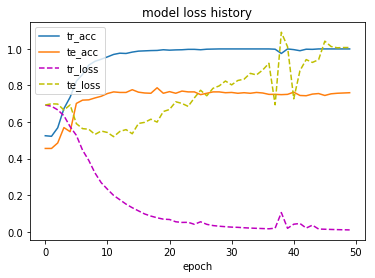

In [34]:
# Seventh setup
# 10 hidden unit
# embedding output dimension : 100
# Balanced class [1000, 1000]


import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'], 'm--')
plt.plot(hist.history['val_loss'], 'y--')
plt.title('model loss history')
# plt.ylabel('loss/acc')
plt.xlabel('epoch')
plt.legend(['tr_acc', 'te_acc','tr_loss', 'te_loss'], loc='upper left')
plt.show()

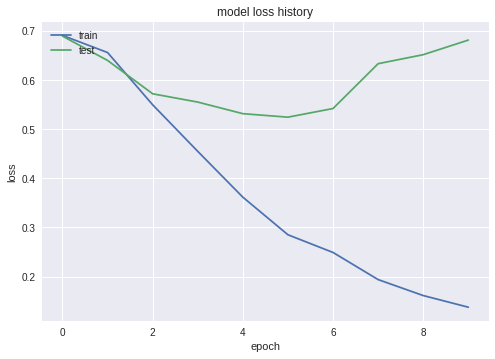

In [60]:
# Seventh setup
# 10 hidden unit
# embedding output dimension : 100
# Balanced class [1000, 1000]


import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

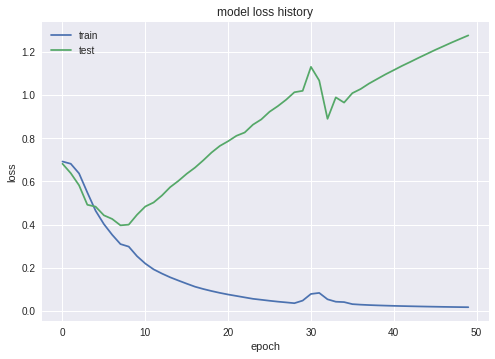

In [37]:
# Sixth setup
# 10 hidden unit
# embedding output dimension : 50

# 0.676 accuracy on final epoch
# 7
# 0.39693

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

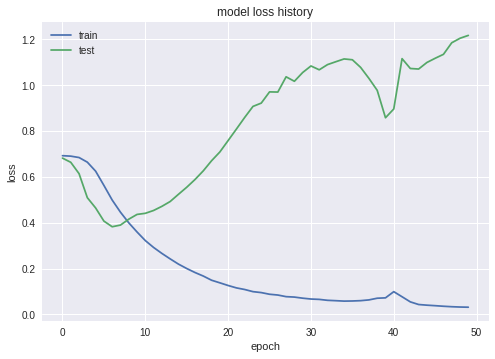

In [94]:
# Fifth setup
# 10 hidden unit
# embedding output dimension : 10

# 0.702 accuracy on final epoch

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

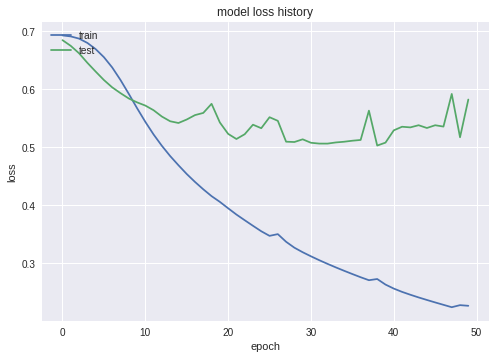

In [84]:
# Fourth setup
# 1 hidden unit

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

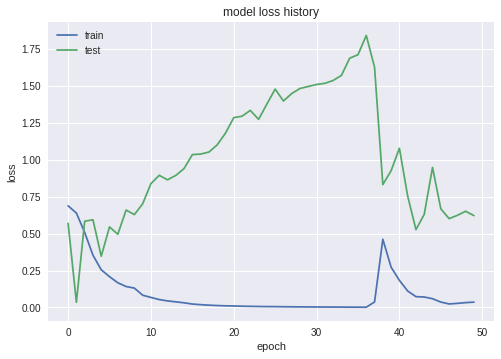

In [69]:
# Third setup
# 100 hidden unit

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

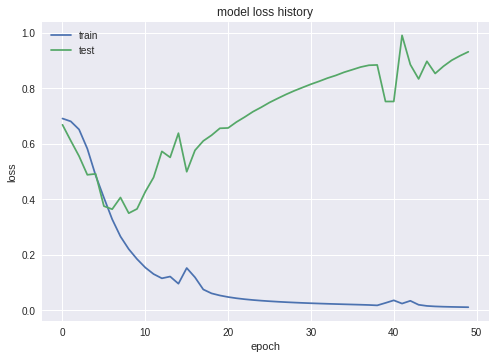

In [50]:
# First setup
# 10 hidden unit

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

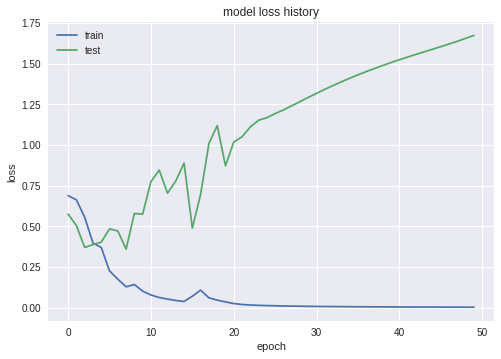

In [61]:
# Second setup
# 50 hidden unit

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Experiment Summary

Global setup :
* 1-gram
* min_df = 1
* total words : 1779
* Total data size : 1201
* Train (70%) : 840
* Val ( 15%) : 180
* Test (15%) : 181

## First setup
* Embedding layer (1779,100) <br>
* LSTM **(10 hidden unit)** <br>
* Output layer (sigmoid) <br>
<br>
* Total params: 182,351 <br>
* Trainable params: 182,351 <br>
* Non-trainable params: 0 <br>
<br>
* argmin epoch : 8 (0.35001) <br>
* Test Accuracy on epoch 

## Second setup

* Embedding layer (1779,100) <br>
* LSTM **(50 hidden unit)** <br>
* Output layer (sigmoid) <br>
* argmin epoch : 7 (0.35971) <br>
* Test Accuracy on epoch 

## Third setup

* Embedding layer (1779,100) <br>
* LSTM **(100 hidden unit)** <br>
* Output layer (sigmoid) <br>
* argmin epoch : 1 (0.35971) <br>
* Test Accuracy on epoch 


In [0]:
# x_train, x_test, y_train, y_test = load_data()

In [0]:
# from sklearn.cross_validation import StratifiedKFold

# def train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test)):
#     model.fit...
#     # fit and evaluate here.

# if __name__ == "__main__":
#     n_folds = 10
#     data, labels, header_info = load_data()
#     skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

#     for i, (train, test) in enumerate(skf):
#             print "Running Fold", i+1, "/", n_folds
#             model = None # Clearing the NN.
#             model = create_model()
#             train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])